# Introduction

This tutorial is created by following along with [this](https://www.tensorflow.org/tutorials/structured_data/feature_columns) tensorflow tutorial. Goals of following the tutorial include:

* Understand how to use structured data (csv, etc) and reshape to input into a model
* Use feature-columns as a bridge to map columns from a source datasource to features used to train a model

# Dataset

We use a simpler version of the [petfinder](https://www.kaggle.com/c/petfinder-adoption-prediction) dataset.

 Column | Description | Feature Type | Data Type
--------|-------------|--------------|------------
Type|Type of animal (Dog, Cat)|Categorical|string
Age|Age of the pet|Numerical|integer
Breed1|Primary breed of the pet|Categorical|string
Color1|Color 1 of pet|Categorical|string
Color2|Color 2 of pet|Categorical|string
MaturitySize|Size at maturity|Categorical|string
FurLength|Fur length|Categorical|string
Vaccinated|Pet has been vaccinated|Categorical|string
Sterilized|Pet has been sterilized|Categorical|string
Health|Health Condition|Categorical|string
Fee|Adoption Fee|Numerical|integer
Description|Profile write-up for this pet|Text|string
PhotoAmt|Total uploaded photos for this pet|Numerical|integer
AdoptionSpeed|Speed of adoption | Classification | integer

# Imports 

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pathlib

# Data Processing

## Load the dataset

In [2]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

In [3]:
tf.keras.utils.get_file(
  'petfinder_mini.zip', dataset_url, extract=True, cache_dir='.')

dataframe = pd.read_csv(csv_file)

# Adoption speed = 4 means unadopted, we do binary classification
dataframe['target'] = np.where(dataframe['AdoptionSpeed'] == 4, 0, 1)

# Drop unused features
del dataframe['AdoptionSpeed']
del dataframe['Description']

# Split data frame into test/train/validation
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

# Show our work
print(len(train), "Train examples")
print(len(test), "Test examples")
print(len(val), "Validation examples")

7383 Train examples
2308 Test examples
1846 Validation examples


In [4]:
train.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
4508,Dog,4,Mixed Breed,Male,Brown,Yellow,Large,Short,Yes,No,Healthy,0,1,0
6843,Cat,48,American Shorthair,Male,Brown,Cream,Small,Short,Yes,Yes,Healthy,0,2,0
8866,Dog,1,Mixed Breed,Female,Black,Brown,Medium,Medium,No,No,Healthy,0,3,1
4605,Dog,2,Mixed Breed,Female,Brown,No Color,Medium,Short,No,Not Sure,Healthy,5,2,0
2789,Dog,17,Australian Shepherd,Female,Black,Brown,Medium,Medium,Yes,Not Sure,Healthy,100,1,0


In [5]:
# This splits a dataframe into series which are mapped to column names, all
# series share the same index.
dict(dataframe).keys()

dict_keys(['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target'])

In [6]:
dict(dataframe)['Age']

0         3
1         1
2         1
3         4
4         1
         ..
11532    24
11533     1
11534     6
11535     9
11536     1
Name: Age, Length: 11537, dtype: int64

In [7]:
def df_to_dataset(df, shuffle=True, batch_size=32):
  df = df.copy(deep=True)
  labels = df.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    # Shuffle the entire dataset.
    ds = ds.shuffle(buffer_size=len(df))
  
  # Configure the dataset to return batches of batch_size
  ds = ds.batch(batch_size)
  return ds

In [8]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)
test_ds = df_to_dataset(test, batch_size=batch_size)
val_ds = df_to_dataset(val, batch_size=batch_size)

In [9]:
# Iterate through one batch
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of ages:', feature_batch['Age'])
  print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([12  2  2  3 60], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([0 1 1 1 1], shape=(5,), dtype=int64)


Okay - so, we have a dictionary of features that is returned from a call to the batch generator - cool!

We can leverage `feature_columns` to further transform the dataframe.

In [10]:
example_batch = next(iter(train_ds))[0]

In [11]:
example_batch

{'Type': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Cat', b'Cat', b'Dog', b'Cat', b'Dog'], dtype=object)>,
 'Age': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([3, 3, 2, 4, 3])>,
 'Breed1': <tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'Domestic Short Hair', b'Domestic Long Hair', b'Mixed Breed',
        b'Domestic Medium Hair', b'Jack Russell Terrier'], dtype=object)>,
 'Gender': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Male', b'Male', b'Male', b'Male', b'Female'], dtype=object)>,
 'Color1': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Brown', b'Black', b'Brown', b'White', b'Brown'], dtype=object)>,
 'Color2': <tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'Golden', b'No Color', b'Cream', b'No Color', b'White'],
       dtype=object)>,
 'MaturitySize': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Medium', b'Medium', b'Medium', b'Large', b'Medium'], dtype=object)>,
 'FurLength': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b

In [12]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  
  # We define the input calculation here using dense feature layer.
  feature_layer = layers.DenseFeatures(feature_column)
  
  # Here, we are operating on the example batch which is in the global scope.
  print(feature_layer(example_batch).numpy())
  print(tf.shape(feature_layer(example_batch)))

Above, we've created a feature layer from a feature column using DenseFeatures - this tells the model to expect input data in the form of a dense Tensor, which is a Tensor where all values are defined in contiguous memory (a performance improvement).

## Numeric columns

The output of a feature column becomes the input to the model (using the demo function defined above, we will be able to see exactly how each column from the dataframe is transformed). A numeric column is the simplest type of column. It is used to represent real valued features. When using this column, your model will receive the column value from the dataframe unchanged.


In [13]:
photo_count = feature_column.numeric_column('PhotoAmt')
demo(photo_count)

[[0.]
 [2.]
 [6.]
 [5.]
 [1.]]
tf.Tensor([5 1], shape=(2,), dtype=int32)


## Bucketized columns

Often, you don't want to feed a number directly into the model, but instead split its value into different categories based on numerical ranges. Consider raw data that represents a person's age. Instead of representing age as a numeric column, we could split the age into several buckets using a bucketized column. Notice the one-hot values below describe which age range each row matches.

Bucketizing works as follows, e.g. for boundaries `[0., 1., 2.]` $\rightarrow$
`[-inf, 0.), [0., 1.), [1., 2.), and [2., +inf)`

In [14]:
age = feature_column.numeric_column('Age')

# Divide data into four buckets:
# Equivalent to 'one-hot' encoding buckets:
# [bucket_1, bucket_2, bucket_3, bucket_4]
# bucket_1 = 1, when -inf <= age < 1
# bucket_2 = 1, when 1 <= age < 3
# bucket_3 = 1, when 3 <= age < 5
# bucket_4 = 1, when 5 <= age < +inf
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 2, 3, 4, 5])

demo(age_buckets)

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]]
tf.Tensor([5 6], shape=(2,), dtype=int32)


In [15]:
example_batch['Age'].numpy()

array([3, 3, 2, 4, 3])

## Categorical columns

In this dataset, Type is represented as a string (e.g. 'Dog', or 'Cat'). We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot vector (much like you have seen above with age buckets). The vocabulary can be passed as a list using categorical_column_with_vocabulary_list, or loaded from a file using categorical_column_with_vocabulary_file.



In [16]:
animal_type = feature_column.categorical_column_with_vocabulary_list(
      'Type', ['Cat', 'Dog'])

animal_type_one_hot = feature_column.indicator_column(animal_type)
demo(animal_type_one_hot)

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]
tf.Tensor([5 2], shape=(2,), dtype=int32)


## Embedding columns

Suppose instead of having just a few possible strings, we have thousands (or more) values per category. For a number of reasons, as the number of categories grow large, it becomes infeasible to train a neural network using one-hot encodings. We can use an embedding column to overcome this limitation. Instead of representing the data as a one-hot vector of many dimensions, an embedding column represents that data as a lower-dimensional, dense vector in which each cell can contain any number, not just 0 or 1. The size of the embedding (8, in the example below) is a parameter that must be tuned.



In [17]:
print(dataframe['Breed1'].unique(), dataframe['Breed1'].nunique())

['Tabby' 'Domestic Medium Hair' 'Mixed Breed' 'Domestic Short Hair'
 'Domestic Long Hair' 'Terrier' 'Persian' 'Rottweiler'
 'Jack Russell Terrier' 'Shih Tzu' 'Labrador Retriever' 'Silky Terrier'
 'Bombay' 'Husky' 'Schnauzer' 'Golden Retriever' 'Siberian Husky' 'Collie'
 'German Shepherd Dog' 'Siamese' 'Calico' 'American Staffordshire Terrier'
 'Turkish Van' 'Doberman Pinscher' 'Oriental Short Hair' 'Beagle'
 'Ragdoll' 'Cocker Spaniel' 'Poodle' 'Black Labrador Retriever' 'Bengal'
 'Shar Pei' 'Spitz' 'Birman' 'Belgian Shepherd Malinois'
 'American Shorthair' 'Belgian Shepherd Laekenois' '0'
 'Jack Russell Terrier (Parson Russell Terrier)' 'Shepherd' 'Corgi'
 'Pit Bull Terrier' 'Oriental Tabby' 'Miniature Pinscher' 'Manx' 'Boxer'
 'Dachshund' 'Chihuahua' 'Snowshoe' 'Rat Terrier' 'Tiger' 'Silver'
 'Maine Coon' 'German Pinscher' 'Russian Blue' 'Tuxedo' 'Lhasa Apso'
 'Pomeranian' 'Whippet' 'English Bulldog' 'Bull Terrier'
 'Yellow Labrador Retriever' 'Dalmatian'
 'West Highland White Terrier

In [18]:
# Notice the input to the embedding column is the categorical column
# we previously created

breed1 = feature_column.categorical_column_with_vocabulary_list('Breed1', dataframe.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
demo(breed1_embedding)

[[ 0.27558586 -0.02141405 -0.15342723 -0.13164552  0.38538918 -0.52284503
   0.40116212 -0.33791885]
 [ 0.3681627   0.2855768  -0.04499963  0.2360308  -0.39788714  0.00523465
   0.2871801   0.15578625]
 [-0.01446695 -0.62306297  0.10713117  0.38678247 -0.14006476 -0.0779836
   0.09667698 -0.16591378]
 [ 0.11650485 -0.4624217  -0.14630806 -0.6280184   0.03861158  0.22639282
  -0.3750416  -0.30670336]
 [-0.08748081 -0.44688854 -0.14367794  0.28977922 -0.20968759  0.38100404
   0.03998243  0.2697332 ]]
tf.Tensor([5 8], shape=(2,), dtype=int32)


Interesting...there are a few other ways to embed large categorical data, which are discussed [here](https://medium.com/ml-book/demonstration-of-tensorflow-feature-columns-tf-feature-column-3bfcca4ca5c4#:~:text=An%20embedding%20column%20stores%20categorical,vector%20than%20an%20indicator%20column.&text=As%20an%20embedding%20column.,contains%20a%203%2Delement%20vector.)

## Hashed feature columns
Another way to represent a categorical column with a large number of values is to use a categorical_column_with_hash_bucket. This feature column calculates a hash value of the input, then selects one of the hash_bucket_size buckets to encode a string. When using this column, you do not need to provide the vocabulary, and you can choose to make the number of hash_buckets significantly smaller than the number of actual categories to save space.

In [19]:
breed1_hashed = feature_column.categorical_column_with_hash_bucket(
      'Breed1', hash_bucket_size=10)
demo(feature_column.indicator_column(breed1_hashed))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
tf.Tensor([ 5 10], shape=(2,), dtype=int32)


## Crossed feature columns

Combining features into a single feature, better known as feature crosses, enables a model to learn separate weights for each combination of features. Here, we will create a new feature that is the cross of Age and Type. Note that crossed_column does not build the full table of all possible combinations (which could be very large). Instead, it is backed by a hashed_column, so you can choose how large the table is.

In [20]:
crossed_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=10)
demo(feature_column.indicator_column(crossed_feature))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
tf.Tensor([ 5 10], shape=(2,), dtype=int32)


# Build a Model with Feature Columns (Arbitrary Selection)

We specify feature_layer_inputs for every feature column that is a direct input, and let tensorflow take care of the rest - for example, the input type for the dog-breed is a string (`tf.string`) even though it gets transformed into buckets of float32.

In [21]:
feature_columns = []
feature_layer_inputs = {}

# numeric cols
for header in ['PhotoAmt', 'Fee', 'Age']:
  feature_columns.append(feature_column.numeric_column(header))
  feature_layer_inputs[header] = tf.keras.Input(shape=(1,), name=header)

# bucketized cols
# This column depends on Age, so we don't hav eto specify an input for it.
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 2, 3, 4, 5])
feature_columns.append(age_buckets)

# indicator_columns
indicator_column_names = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                          'FurLength', 'Vaccinated', 'Sterilized', 'Health']
for col_name in indicator_column_names:
  categorical_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, dataframe[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)
  feature_layer_inputs[col_name] = tf.keras.Input(shape=(1,), name=col_name, dtype=tf.string)

# embedding columns
breed1 = feature_column.categorical_column_with_vocabulary_list(
      'Breed1', dataframe.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
feature_columns.append(breed1_embedding)
feature_layer_inputs['Breed1'] = tf.keras.Input(shape=(8,), name='Breed1', dtype=tf.string)

# crossed columns
# This feature is a cross, so we define inputs separately.
age_type_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=100)
feature_columns.append(feature_column.indicator_column(age_type_feature))

# Create the input layer, which takes the feature columns.
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [22]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

## Sequential API Solution

```python
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])
```

## Functional API Solution

In [43]:
# outputs is the input into the model
feature_layer_outputs = feature_layer(feature_layer_inputs)
l1 = layers.Dense(128, activation='relu')(feature_layer_outputs)
l2 = layers.Dense(128, activation='relu')(l1)
l3 = layers.Dropout(.1)(l2)
prediction = layers.Dense(1)(l3)

model = tf.keras.Model(inputs=[v for v in feature_layer_inputs.values()], outputs=prediction)

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=['accuracy']
)

## Example - Manually Executing the Layers

In [41]:
type(train_batch)

tuple

In [44]:
train_batch[0]

{'Type': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Dog', b'Cat', b'Cat', b'Cat', b'Dog'], dtype=object)>,
 'Age': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 2,  1, 12,  2,  2])>,
 'Breed1': <tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'Mixed Breed', b'Domestic Short Hair', b'Domestic Short Hair',
        b'Domestic Short Hair', b'Mixed Breed'], dtype=object)>,
 'Gender': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Male', b'Male', b'Male', b'Male', b'Male'], dtype=object)>,
 'Color1': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Brown', b'Golden', b'Black', b'Black', b'Black'], dtype=object)>,
 'Color2': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'No Color', b'White', b'Brown', b'White', b'Brown'], dtype=object)>,
 'MaturitySize': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Medium', b'Medium', b'Large', b'Small', b'Medium'], dtype=object)>,
 'FurLength': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Short', b'Short', 

In [45]:
feature_layer(train_batch[0])

<tf.Tensor: shape=(5, 150), dtype=float32, numpy=
array([[ 2.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.000

In [48]:
layers.Dense(128, activation='relu')(feature_layer(train_batch[0]))

<tf.Tensor: shape=(5, 128), dtype=float32, numpy=
array([[0.00000000e+00, 5.04564345e-01, 7.69307852e-01, 0.00000000e+00,
        4.34136212e-01, 6.70226887e-02, 4.50785607e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.11346997e-01, 7.82729983e-01, 2.14349434e-01, 2.31610641e-01,
        0.00000000e+00, 1.24155819e-01, 0.00000000e+00, 0.00000000e+00,
        3.77183497e-01, 0.00000000e+00, 1.70730963e-01, 2.13714719e-01,
        9.46536899e-01, 2.73239553e-01, 0.00000000e+00, 1.55462995e-01,
        0.00000000e+00, 2.17183813e-01, 4.36451286e-03, 0.00000000e+00,
        5.26980877e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.70337963e-01, 1.78794950e-01, 4.79683936e-01, 4.19380784e-01,
        1.37149870e-01, 0.00000000e+00, 1.30069271e-01, 2.78143227e-01,
        0.00000000e+00, 6.13838434e-03, 0.00000000e+00, 6.82151437e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.20796925e-02,
        1.2458

In [110]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
231/231 [==============================] - 2s 8ms/step - loss: 0.6953 - accuracy: 0.7005 - val_loss: 0.6136 - val_accuracy: 0.7438
Epoch 2/10
231/231 [==============================] - 1s 6ms/step - loss: 0.5601 - accuracy: 0.7215 - val_loss: 0.5635 - val_accuracy: 0.6950
Epoch 3/10
231/231 [==============================] - 1s 6ms/step - loss: 0.5081 - accuracy: 0.7356 - val_loss: 0.4950 - val_accuracy: 0.7492
Epoch 4/10
231/231 [==============================] - 1s 6ms/step - loss: 0.5015 - accuracy: 0.7356 - val_loss: 0.4945 - val_accuracy: 0.7492
Epoch 5/10
231/231 [==============================] - 1s 6ms/step - loss: 0.4926 - accuracy: 0.7356 - val_loss: 0.4937 - val_accuracy: 0.7514
Epoch 6/10
231/231 [==============================] - 1s 6ms/step - loss: 0.4828 - accuracy: 0.7422 - val_loss: 0.4987 - val_accuracy: 0.7486
Epoch 7/10
231/231 [==============================] - 1s 6ms/step - loss: 0.4781 - accuracy: 0.7485 - val_loss: 0.5140 - val_accuracy: 0.7589
Epoch 

In [111]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Age (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed1 (InputLayer)             [(None, 8)]          0                                            
__________________________________________________________________________________________________
Color1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Color2 (InputLayer)             [(None, 1)]          0                                            
_______________________________________________________________________________________

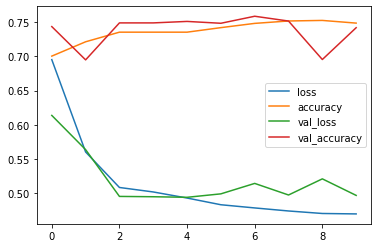

In [114]:
pd.DataFrame(history.history).plot()

In [115]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)


73/73 [==============================] - 0s 4ms/step - loss: 0.4970 - accuracy: 0.7400
Accuracy 0.7400346398353577
